# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from functions import *
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, Normalizer, MinMaxScaler
from sklearn import preprocessing
import scipy.stats as stats
from scipy.special import inv_boxcox
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
import matplotlib.ticker as ticker
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics


warnings.filterwarnings('ignore')

In [2]:
rent_df = pd.read_csv('/Users/ignaciolorenzoqueralt/Documents/Ironhack/Final Project/properties/rent/2021.11.17_cataluña_1300_5.csv', engine='python' )
rent_df = rent_df.loc[:, ~rent_df.columns.str.contains('^Unnamed')]

# Working on the data

### Adding sqm price for each neighborhood

In [3]:
rent_df['hood_price_m2'] = ""

for index, row in rent_df.iterrows():
    hood_price_m2 = rent_df[rent_df['neighborhood'] == rent_df['neighborhood'][index]]['price_m2'].mean()
    rent_df['hood_price_m2'][index] = hood_price_m2

### Cleaning the data

- Replacing nulls from last_update:

In [4]:
clean_last_update(rent_df, c = 'last_update')

- Replacing null values of lift column with 'no'. All properties with no lift data don't have a lift.

In [5]:
fill_lift_column(rent_df)

- Dealing with null values

In [6]:
checking_nulls(rent_df)

The column  area  has  11  null values
The column  floor  has  2511  null values
The column  ccaa  has  22  null values
The column  description  has  11  null values
The column  geo_town  has  36  null values
The column  m2  has  36  null values
The column  n_bath  has  36  null values
The column  n_rooms  has  36  null values
The column  name  has  36  null values
The column  neighborhood  has  36  null values
The column  opportunity  has  36  null values
The column  price  has  36  null values
The column  price_m2  has  61  null values
The column  price_reduction  has  61  null values
The column  province  has  61  null values
The column  url  has  61  null values
The column  hood_price_m2  has  61  null values


In [7]:
rent_df = rent_df.dropna()

In [8]:
rent_df.head(1)

,area,floor,ccaa,description,geo_town,last_update,lift,m2,n_bath,n_rooms,name,neighborhood,opportunity,price,price_m2,price_reduction,province,url,hood_price_m2
1,Arenys de Mar,first,cataluña,INMUEBLE NO SUJETO A LA LIMITACIÓN DE PRECIOS ...,arenys_de_mar,0.0,yes,70,1,3.0,Alquiler Apartamento N ii junquera. Por meses...,Urbanitzacions,no,900,12.0,80.0,barcelona,https://www.habitaclia.com/alquiler-apartament...,9.368421


- Creating df with the neighborhoods of the df and its hood_price_m2:

In [9]:
neighborhood_price_sqm = rent_df[['neighborhood','geo_town','hood_price_m2']].copy()
neighborhood_price_sqm.drop_duplicates(keep=False,inplace=True)
neighborhood_price_sqm = neighborhood_price_sqm.reset_index(drop=True)
neighborhood_price_sqm.head(3)

,neighborhood,geo_town,hood_price_m2
0,Zona alta,arenys_de_mar,9.333333
1,Nucli Urbà,argentona,8.384615
2,Montigalà,badalona,12.0


- Cleaning numerical variables

In [10]:
numericals = ['m2', 'n_rooms', 'n_bath', 'price_m2', 'price', 'price_reduction', 'last_update', 'hood_price_m2']
convert_to_numerical(rent_df, numericals)

- Filtering out towns in which there are less than x properties listed.

In [11]:
filtered_towns = list(rent_df['geo_town'].value_counts()[lambda x: x > 10].index)
rent_df = rent_df[rent_df['geo_town'].isin(filtered_towns)]

# Exploratory analysis

In [12]:
rent_df.head(3)

,area,floor,ccaa,description,geo_town,last_update,lift,m2,n_bath,n_rooms,name,neighborhood,opportunity,price,price_m2,price_reduction,province,url,hood_price_m2
1,Arenys de Mar,first,cataluña,INMUEBLE NO SUJETO A LA LIMITACIÓN DE PRECIOS ...,arenys_de_mar,0,yes,70,1,3,Alquiler Apartamento N ii junquera. Por meses...,Urbanitzacions,no,900,12,80,barcelona,https://www.habitaclia.com/alquiler-apartament...,9
2,Arenys de Mar,fourth,cataluña,Vivienda en la Urbanización Carolines de Areny...,arenys_de_mar,8,yes,89,1,2,"Alquiler Piso en Carrer mig (del), 20. Vivie...",Urbanitzacions,no,680,7,20,barcelona,https://www.habitaclia.com/alquiler-piso-vivie...,9
4,Arenys de Mar,second,cataluña,ALQUILER DE TEMPORADA - Bonito piso de 70 m2 t...,arenys_de_mar,13,yes,70,1,3,Alquiler Apartamento Carrer camí ral del caba...,Urbanitzacions,no,900,12,80,barcelona,https://www.habitaclia.com/alquiler-apartament...,9


In [13]:
rent_df.shape

(2276, 19)

In [14]:
rent_df.dtypes

area               object
floor              object
ccaa               object
description        object
geo_town           object
last_update         int64
lift               object
m2                  int64
n_bath              int64
n_rooms             int64
name               object
neighborhood       object
opportunity        object
price               int64
price_m2            int64
price_reduction     int64
province           object
url                object
hood_price_m2       int64
dtype: object

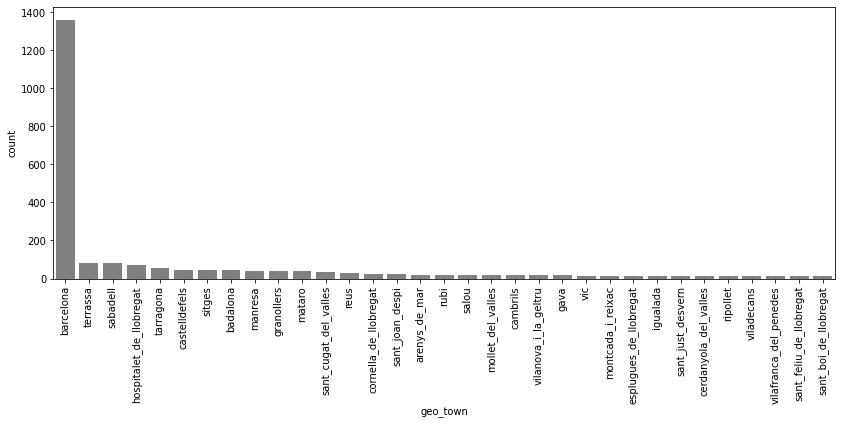

In [15]:
countplot(rent_df,c = "geo_town")

# Models:

#### Separating big from small cities

In [16]:
model_df_small = rent_df[rent_df['geo_town'] != filtering_big_cities(rent_df)]
model_df_big = rent_df[rent_df['geo_town'] == filtering_big_cities(rent_df)]

#### Feature selection for big and small cities:

We skip neighborhood as it would add too many distinct categorical values which would increase too much the size of the model when encoding it.

In [17]:
model_df_small = model_df_small[['m2', 'n_rooms', 'n_bath', 'last_update', 'geo_town', 'province', 'ccaa', 'price', 'lift', 'floor', 'hood_price_m2']].copy()
model_df_big = model_df_big[['geo_town', 'm2', 'n_rooms', 'n_bath', 'last_update', 'price', 'lift', 'floor', 'hood_price_m2', 'neighborhood']].copy()

#### Removing outliers

In [18]:
model_df_small = remove_outliers(model_df_small, threshold=1.5, in_columns = ['m2', 'n_rooms', 'last_update', 'price', 'hood_price_m2'])
model_df_big = remove_outliers(model_df_big, threshold=1.5, in_columns = ['m2', 'n_rooms', 'last_update', 'price', 'hood_price_m2'])

In [19]:
model_df_small.shape

(693, 11)

In [20]:
model_df_big.shape

(1297, 10)

#### Visualizing our data

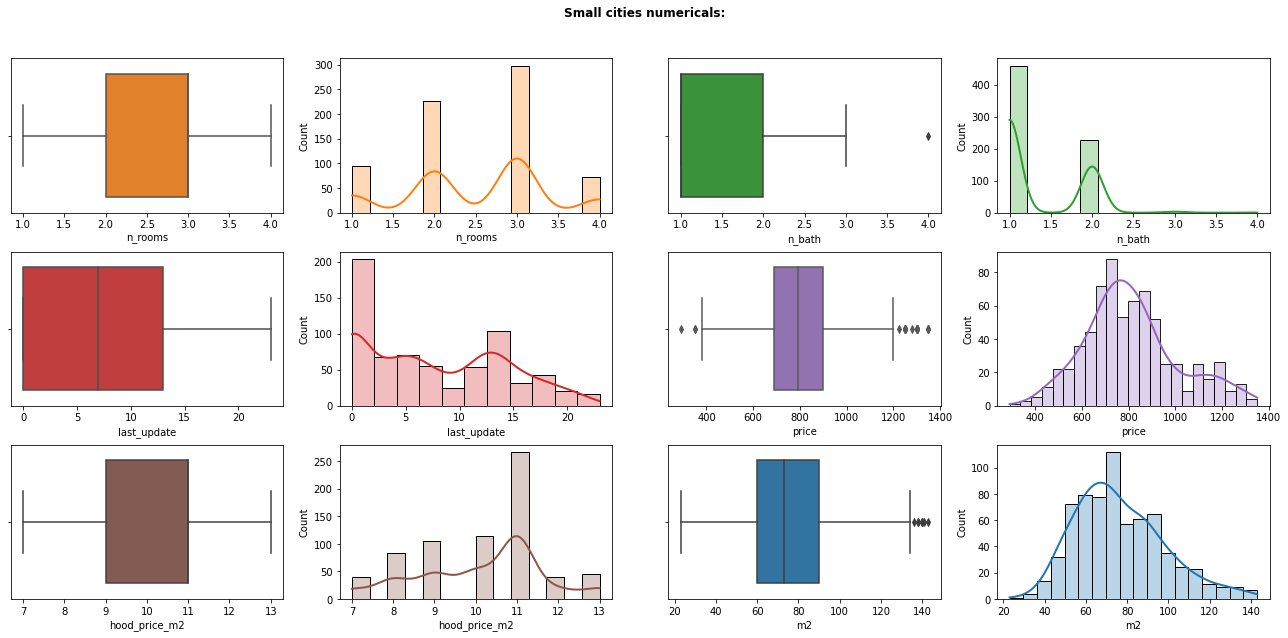

In [21]:
plot_numericals(model_df_small, title = "Small cities numericals:")

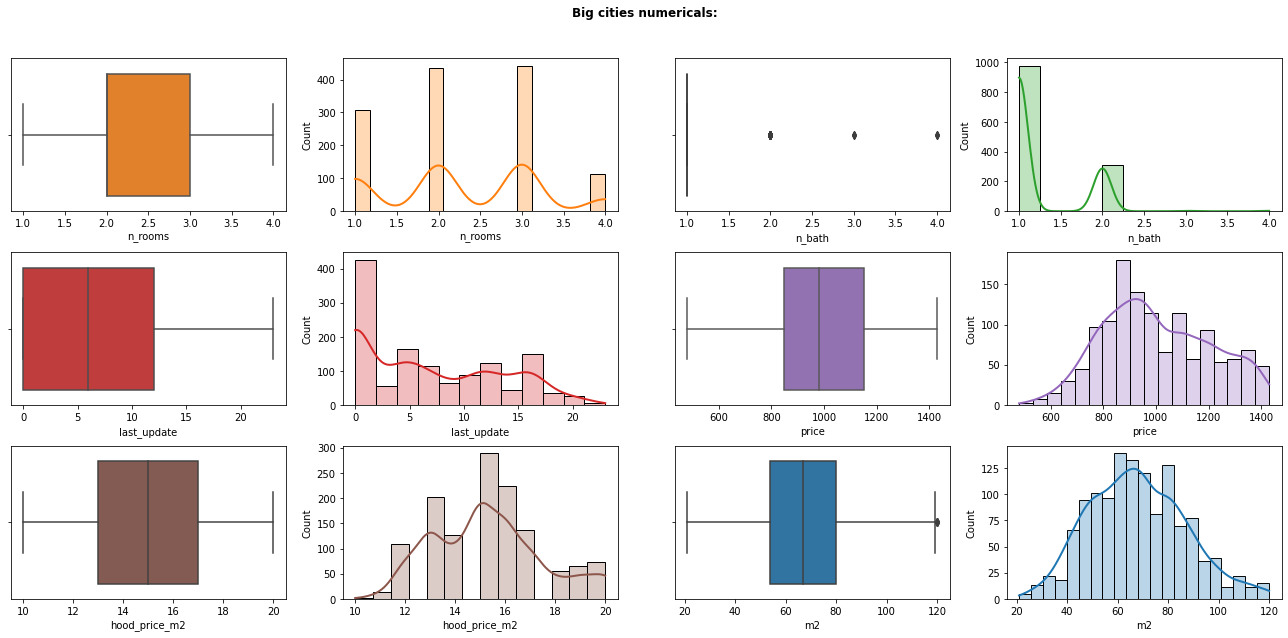

In [22]:
plot_numericals(model_df_big, title = "Big cities numericals:")

## plot_categorical(model_df_small, title = "Small cities: categoricals", delete_n = [5])

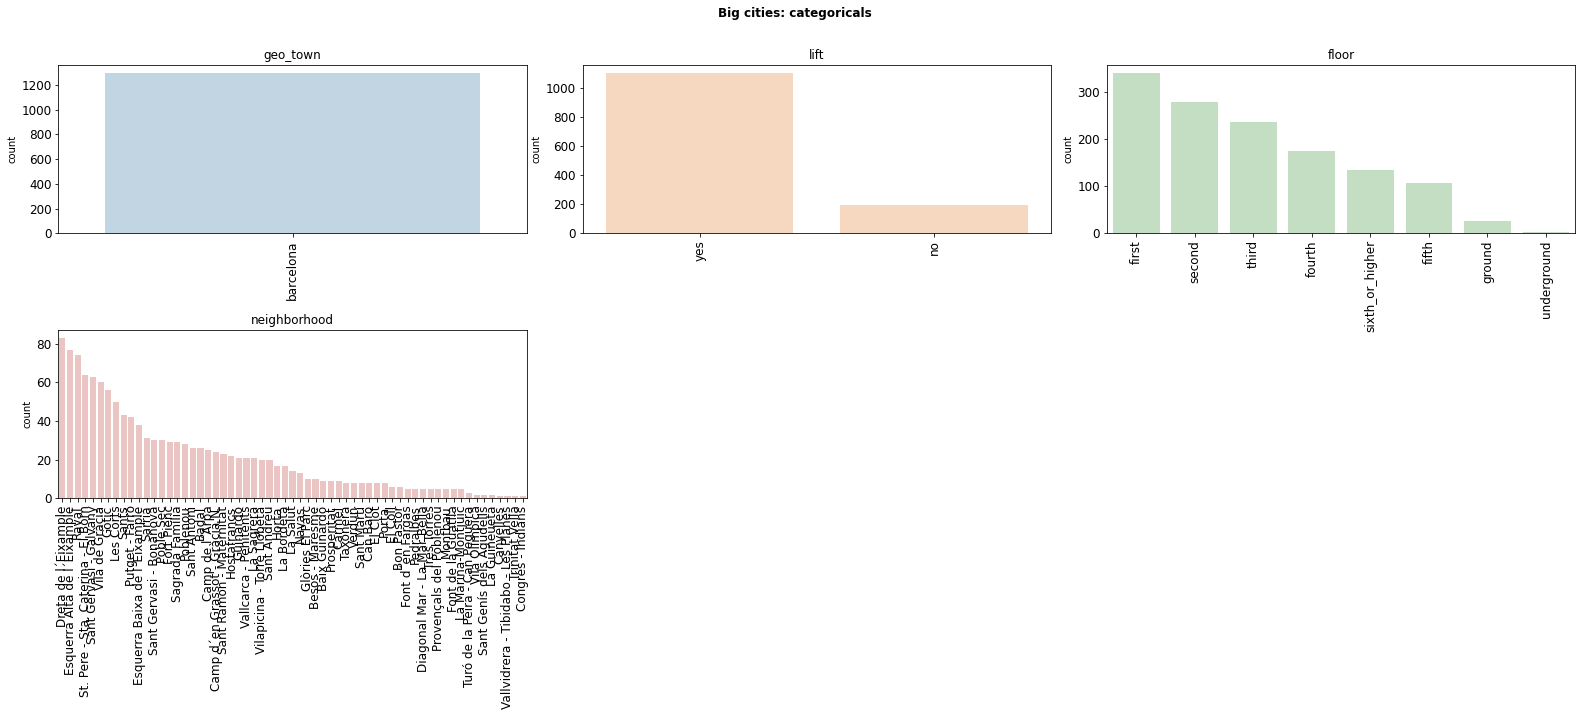

In [23]:
plot_categorical(model_df_big, title = "Big cities: categoricals", delete_n = [4,5])

#### X-y Split

In [24]:
X_sma = model_df_small.drop('price', axis=1)
y_sma = model_df_small[['price']].copy()

X_big = model_df_big.drop('price', axis=1)
y_big = model_df_big[['price']].copy()

#### Encoding categoricals and normalizing numericals

In [25]:
X_sma_cat = X_sma.select_dtypes('object')
X_sma_num = X_sma.select_dtypes('int')

X_sma_cat_enc = pd.get_dummies(X_sma_cat, drop_first=True)
X_sma_num_norm, _ci = boxcox_transform(X_sma_num)

X_sma = np.concatenate([X_sma_num_norm, X_sma_cat_enc], axis=1)
X_sma.shape

(693, 44)

In [26]:
X_big_cat = X_big.select_dtypes('object')
X_big_num = X_big.select_dtypes('int')

X_big_cat_enc = pd.get_dummies(X_big_cat, drop_first=True)
X_big_num_norm, _ci = boxcox_transform(X_big_num)

X_big = np.concatenate([X_big_num_norm, X_big_cat_enc], axis=1)
X_big.shape

(1297, 73)

#### Train-test split

In [27]:
X_sma_train, X_sma_test, y_sma_train, y_sma_test = train_test_split(X_sma, y_sma, test_size=0.3, random_state=10)
X_big_train, X_big_test, y_big_train, y_big_test = train_test_split(X_big, y_big, test_size=0.3, random_state=10)

#### Finding the best algorithm for the big and small city model.

In [28]:
model_comparisson = pd.DataFrame(columns = ['city_type', 'model', 'r2', 'mean_absolute_error', 'mean_squared_error'])

In [ ]:
pipe = Pipeline(steps=[('estimator', LinearRegression())])

params_grid = [ {'estimator':[LinearRegression()],
                },
               {'estimator': [RandomForestRegressor()],
               'estimator__n_estimators':[10, 50, 100, 200, 300, 500, 600],
                'estimator__max_depth':[1, 2, 3, 4, 5, 6, 7, None],
                'estimator__min_samples_split':[2, 3, 4, 5, None],
                'estimator__min_samples_leaf':[1, 2, 3, 4, 5],
               }
              ]
"""
params_grid = [
               {'estimator': [RandomForestRegressor()],
               'estimator__n_estimators':[10],
                'estimator__max_depth':[1, 2],
                'estimator__min_samples_split':[2, 3],
                'estimator__min_samples_leaf':[1, 2],
               }
              ]
"""
grid = GridSearchCV(pipe, params_grid, n_jobs =-1, verbose = 2)
res = grid.fit(X_sma, y_sma)

grid.best_params_

sma_grid_results = pd.DataFrame(grid.cv_results_)
sma_grid_results = sma_grid_results.sort_values(by="rank_test_score", ignore_index=True)

Fitting 5 folds for each of 1401 candidates, totalling 7005 fits


In [ ]:
pipe = Pipeline(steps=[('estimator', LinearRegression())])

params_grid = [ {'estimator':[LinearRegression()],
                },
               {'estimator': [RandomForestRegressor()],
               'estimator__n_estimators':[10, 50, 100, 200, 300, 500, 600],
                'estimator__max_depth':[1, 2, 3, 4, 5, 6, 7, None],
                'estimator__min_samples_split':[2, 3, 4, 5, None],
                'estimator__min_samples_leaf':[1, 2, 3, 4, 5],
               }
              ]
"""
params_grid = [
               {'estimator': [RandomForestRegressor()],
               'estimator__n_estimators':[10],
                'estimator__max_depth':[1, 2],
                'estimator__min_samples_split':[2, 3],
                'estimator__min_samples_leaf':[1, 2],
               }
              ]
"""

grid = GridSearchCV(pipe, params_grid, n_jobs =-1, verbose = 2)
res = grid.fit(X_big, y_big)

grid.best_params_

big_grid_results = pd.DataFrame(grid.cv_results_)
big_grid_results = big_grid_results.sort_values(by="rank_test_score", ignore_index=True)

In [ ]:
sma_grid_results.head(3)

In [ ]:
big_grid_results.head(3)

#### Fitting LinearRegression to Big & Small data

In [ ]:
reg_sma_city = LinearRegression()
reg_big_city = LinearRegression()

reg_sma_city.fit(X_sma_train, y_sma_train)
reg_big_city.fit(X_big_train, y_big_train)

reg_sma_predictions = reg_sma_city.predict(X_sma_test)
reg_big_predictions = reg_big_city.predict(X_big_test)

reg_sma_r2 = r2_score(y_sma_test, reg_sma_predictions)
reg_big_r2 = r2_score(y_big_test, reg_big_predictions)

In [ ]:
row_reg_sma_r2 = {'city_type':'small', 'model':reg_sma_city, 'r2':reg_sma_r2, 'mean_absolute_error':mean_absolute_error(y_sma_test, reg_sma_predictions), 'mean_squared_error':mean_squared_error(y_sma_test, reg_sma_predictions, squared=False)}
row_reg_big_r2 = {'city_type':'big', 'model':reg_big_city, 'r2':reg_big_r2, 'mean_absolute_error':mean_absolute_error(y_big_test, reg_big_predictions), 'mean_squared_error':mean_squared_error(y_big_test, reg_big_predictions, squared=False)}

model_comparisson = model_comparisson.append(row_reg_sma_r2, ignore_index=True)
model_comparisson = model_comparisson.append(row_reg_big_r2, ignore_index=True)

#### Fitting the best RandomForestRegressor() to Big & Small data

In [ ]:
rf_sma_city = sma_grid_results['param_estimator'][0]
rf_big_city = big_grid_results['param_estimator'][0]

rf_sma_city.fit(X_sma_train, y_sma_train)
rf_big_city.fit(X_big_train, y_big_train)

rf_sma_predictions = rf_sma_city.predict(X_sma_test)
rf_big_predictions = rf_big_city.predict(X_big_test)

rf_sma_r2 = metrics.r2_score(y_sma_test, rf_sma_predictions)
rf_big_r2 = metrics.r2_score(y_big_test, rf_big_predictions)

row_rf_sma_r2 = {'city_type':'small', 'model':rf_sma_city, 'r2':rf_sma_r2, 'mean_absolute_error':mean_absolute_error(y_sma_test, rf_sma_predictions), 'mean_squared_error':mean_squared_error(y_sma_test, rf_sma_predictions, squared=False)}
row_rf_big_r2 = {'city_type':'big', 'model':rf_big_city, 'r2':rf_big_r2, 'mean_absolute_error':mean_absolute_error(y_big_test, rf_big_predictions), 'mean_squared_error':mean_squared_error(y_big_test, rf_big_predictions, squared=False)}

model_comparisson = model_comparisson.append(row_rf_sma_r2, ignore_index=True)
model_comparisson = model_comparisson.append(row_rf_big_r2, ignore_index=True)

In [ ]:
model_comparisson

In [ ]:
y_sma_test['reg_predicted'] = reg_sma_predictions
y_sma_test['rf_predicted'] = rf_sma_predictions

y_sma_test['reg_difference_%'] = ((y_sma_test['reg_predicted']-y_sma_test['price'])/y_sma_test['reg_predicted'])*100
y_sma_test['rf_difference_%'] = ((y_sma_test['rf_predicted']-y_sma_test['price'])/y_sma_test['rf_predicted'])*100

y_big_test['reg_predicted'] = reg_big_predictions
y_big_test['rf_predicted'] = rf_big_predictions

y_big_test['reg_difference_%'] = ((y_big_test['reg_predicted']-y_big_test['price'])/y_big_test['reg_predicted'])*100
y_big_test['rf_difference_%'] = ((y_big_test['rf_predicted']-y_big_test['price'])/y_big_test['rf_predicted'])*100

In [ ]:
model_plots(y_sma_test, title = "Small cities: \n LinearRegression() vs RandomForestRegressor()")

In [ ]:
model_plots(y_big_test, title = "Big cities: \n LinearRegression() vs RandomForestRegressor()")

In [ ]:
sns.jointplot(x=y_sma_test.price, y=y_sma_test.reg_predicted, kind="hex", color="#4CB391")
print("Small cities: Linear Regression jointplot")

In [ ]:
sns.jointplot(x=y_big_test.price, y=y_big_test.rf_predicted, kind="hex", color="#4CB391")
print("Big cities: RanfomForestRegression jointplot")


#### Evaluating variables

In [ ]:
# check the correlations
mask = np.zeros_like(rent_df.corr())
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

fig, ax = plt.subplots(figsize=(7, 7))
ax = sns.heatmap(rent_df.corr(), mask=mask, annot=True)
plt.show()

In [ ]:
X_sma = model_df_small.drop('price', axis=1)
y_sma = model_df_small[['price']].copy()

X_big = model_df_big.drop('price', axis=1)
y_big = model_df_big[['price']].copy()

feature_list_sma = list(X_sma.columns)
feature_list_big = list(X_big.columns)

importances_sma = list(rf_sma_city.feature_importances_)
importances_big = list(rf_big_city.feature_importances_)

feature_importances_sma = [(feature, round(importance, 2)) for feature, importance in zip(feature_list_sma, importances_sma)]
feature_importances_sma = sorted(feature_importances_sma, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances_sma]
print('\n')

feature_importances_big = [(feature, round(importance, 2)) for feature, importance in zip(feature_list_big, importances_big)]
feature_importances_big = sorted(feature_importances_big, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances_big]


## Finding the most profitable towns to Buy & Rent

1. Importar df con propiedades en venta
2. Distinguir entre propiedades que pertenecen a modelo de ciudad grande o pequeña
- Seleccionar varialbes de un modelo y de otro
- filtrar poblaciones de propiedades en venta que no estan en los municipios del modelo
3. Sacar tabla de predicciones para modelo grande y pequeña
4. concatenar tabla de predicciones
5. Merge con info de precios de venta
6. Calcular ROI
7. Visualizacion

### Importar df con propiedades en venta

In [ ]:
df_sale = pd.read_csv('/Users/ignaciolorenzoqueralt/Documents/Ironhack/Final Project/properties/sale/2021.11.15_cataluña_90000_10.csv', engine = 'python')

### Distinguir entre propiedades que pertenecen a modelo de ciudad grande o pequeña

In [ ]:
df_sale_big = df_sale[df_sale['geo_town'] == filtering_big_cities(model_df)]
df_sale_small = df_sale[df_sale['geo_town'] != filtering_big_cities(model_df)]

#### Cleaning big city sale df

In [ ]:
df_sale_big['hood_price_m2'] = ""

In [ ]:
df_sale_big = df_sale_big[['geo_town', 'm2', 'n_rooms', 'n_bath', 'last_update', 'price', 'lift', 'floor', 'hood_price_m2', 'neighborhood']].copy()

In [ ]:
clean_last_update(df_sale_big, c = 'last_update')

In [ ]:
fill_lift_column(df_sale_big)

In [ ]:
checking_nulls(df_sale_big)

In [ ]:
df_sale_big = df_sale_big.dropna()

In [ ]:
df_sale_big.shape

In [ ]:
df_sale_big1 = df_sale_big.copy()

In [ ]:
df_sale_big1 = df_sale_big1.merge(neighborhood_price_sqm, on='neighborhood', how='inner')
df_sale_big1 = df_sale_big1.drop(["geo_town_x", "hood_price_m2_x"], axis = 1)
df_sale_big1.columns = ['m2', 'n_rooms', 'n_bath', 'last_update', 'price', 'lift', 'floor', 'neighborhood', 'geo_town', 'hood_price_m2']

In [ ]:
new_row = {'geo_town':'dumb', 'm2':87, 'n_rooms':92, 'n_bath':97, 'last_update':97, 'price':97, 'lift':'yes', 'floor':"ground", 'hood_price_m2':97, 'neighborhood': 'Eixample'}
df_sale_big1 = df_sale_big1.append(new_row, ignore_index=True)

In [ ]:
numericals = ['m2', 'n_rooms', 'n_bath', 'price', 'last_update', 'hood_price_m2']
convert_to_numerical(df_sale_big1, numericals)

In [ ]:
X_cat = df_sale_big1.select_dtypes('object')
X_num = df_sale_big1.select_dtypes('int')

In [ ]:
X_cat_enc = pd.get_dummies(X_cat, drop_first=True)
X_num_norm, _ci = boxcox_transform(X_num)
X = np.concatenate([X_num_norm, X_cat_enc], axis=1)
X.shape

### Fit model to both dfs

In [ ]:
predictions_big_city = model_big_city.predict(X)

# Si mi modelo es para predecir precios que no estan en el df del train test, una vez optimizado el modelo, que sentido tiene tener un test split?